# maxvogt-analysis: Effretikon

The code in this notebook is based on [Martin Fleischmann's](https://martinfleischmann.net/) 2021 workshop [*Capturing the Structure of Cities with Data Science (SDSC)*](https://github.com/martinfleis/sdsc21-workshop), licensed under the [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/). © 2021 Martin Fleischmann.

The geodata in this notebook is retrieved from OpenStreetMap. © OpenStreetMap Contributors.

<hr>

This notebook contains geodata and analyses for the following items of the [Max Vogt collection](https://mtwente.github.io/maxvogt/) by Moritz Twente and Luisa Omonsky:
- [EF010](https://mtwente.github.io/maxvogt/items/ef010.html)
- [EF013](https://mtwente.github.io/maxvogt/items/ef013.html)
- [EF026](https://mtwente.github.io/maxvogt/items/ef026.html)
- [EF042](https://mtwente.github.io/maxvogt/items/ef042.html)

<hr>

Open in an interactive in-browser environment: 

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/mtwente/maxvogt-analysis/main?labpath=analysis%2Feffretikon.ipynb)

In [78]:
import warnings

import geopandas
import libpysal
import momepy
import osmnx
import pandas

from clustergram import Clustergram

import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bokeh.plotting import show

Pick a place, ideally a town with a good coverage in OpenStreetMap and its local CRS.

In [79]:
place = 'Effretikon'
local_crs = 'EPSG:2056'

In [80]:
geopandas.tools.geocode(place).explore()

## Input data

Download data from OpenStreetMap.

### Buildings

In [81]:
buildings = osmnx.features.features_from_place(place, tags={'building':True})

/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


In [82]:
buildings

man_made  \
element_type osmid                 
way          10698615        NaN   
             10861441        NaN   
             27338285        NaN   
             27349588        NaN   
             27349604        NaN   
...                          ...   
             1304854438      NaN   
             1304854440      NaN   
             1305831668      NaN   
             1305831671      NaN   
relation     1169711         NaN   

                                                                  geometry  \
element_type osmid                                                           
way          10698615    POLYGON ((8.68686 47.42614, 8.68675 47.42617, ...   
             10861441    POLYGON ((8.70114 47.42318, 8.70137 47.42305, ...   
             27338285    POLYGON ((8.72579 47.39835, 8.72614 47.39856, ...   
             27349588    POLYGON ((8.74348 47.41108, 8.74380 47.41099, ...   
             27349604    POLYGON ((8.74354 47.42208, 8.74387 47.42213, ...   
...                                                                    ...   
             1304854438  POLYGON ((8.74528 47.40636, 8.74522 47.40639, ...   
             1304854440  POLYGON ((8.74416 47.40664, 8.74418 47.40673, ...   
             1305831668  POLYGON ((8.74174 47.40538, 8.74185 47.40540, ...   
             1305831671  POLYGON ((8.74148 47.41016, 8.74147 47.41017, ...   
relation     1169711     POLYGON ((8.74304 47.45829, 8.74288 47.45847, ...   

                        amenity operator operator:de operator:en operator:fr  \
element_type osmid                                                             
way          10698615       NaN      NaN         NaN         NaN         NaN   
             10861441    school      NaN         NaN         NaN         NaN   
             27338285       NaN      NaN         NaN         NaN         NaN   
             27349588       NaN      NaN         NaN         NaN         NaN   
             27349604       NaN      NaN         NaN         NaN         NaN   
...                         ...      ...         ...         ...         ...   
             1304854438     NaN      NaN         NaN         NaN         NaN   
             1304854440     NaN      NaN         NaN         NaN         NaN   
             1305831668     NaN      NaN         NaN         NaN         NaN   
             1305831671     NaN      NaN         NaN         NaN         NaN   
relation     1169711        NaN      NaN         NaN         NaN         NaN   

                        operator:it operator:rm operator:wikidata  ...  \
element_type osmid                                                 ...   
way          10698615           NaN         NaN               NaN  ...   
             10861441           NaN         NaN               NaN  ...   
             27338285           NaN         NaN               NaN  ...   
             27349588           NaN         NaN               NaN  ...   
             27349604           NaN         NaN               NaN  ...   
...                             ...         ...               ...  ...   
             1304854438         NaN         NaN               NaN  ...   
             1304854440         NaN         NaN               NaN  ...   
             1305831668         NaN         NaN               NaN  ...   
             1305831671         NaN         NaN               NaN  ...   
relation     1169711            NaN         NaN               NaN  ...   

                        automated roof:material building:levels:underground  \
element_type osmid                                                            
way          10698615         NaN           NaN                         NaN   
             10861441         NaN           NaN                         NaN   
             27338285         NaN           NaN                         NaN   
             27349588         NaN           NaN                         NaN   
             27349604         NaN           NaN               

In [83]:
buildings.geom_type.value_counts()

Polygon    4169
Name: count, dtype: int64

In [84]:
buildings = buildings[buildings.geom_type == "Polygon"].reset_index(drop=True)

In [85]:
buildings = buildings[["geometry"]].to_crs(local_crs)

In [86]:
buildings["uID"] = range(len(buildings))

In [87]:
buildings

geometry   uID
0     POLYGON ((2694178.455 1253564.090, 2694170.145...     0
1     POLYGON ((2695261.161 1253252.357, 2695278.420...     1
2     POLYGON ((2697166.106 1250522.008, 2697191.729...     2
3     POLYGON ((2698478.041 1251958.745, 2698502.345...     3
4     POLYGON ((2698462.227 1253182.282, 2698486.573...     4
...                                                 ...   ...
4164  POLYGON ((2698622.204 1251436.876, 2698617.650...  4164
4165  POLYGON ((2698537.137 1251466.640, 2698538.748...  4165
4166  POLYGON ((2698357.328 1251323.329, 2698365.411...  4166
4167  POLYGON ((2698328.852 1251854.319, 2698327.969...  4167
4168  POLYGON ((2698357.244 1257206.491, 2698344.541...  4168

[4169 rows x 2 columns]

### Streets

In comparison to Martin Fleischmann's workshop, I here set `truncate_by_edge` to be `True`.
Depending on the OSM mapping quality of the place at hand, it might also be necessary to change the value of `network_type`. See [geopandas documentation](https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.graph.graph_from_place) for options.

In [88]:
osm_graph = osmnx.graph_from_place(place, network_type='drive', truncate_by_edge=True)

/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


In [89]:
osm_graph = osmnx.projection.project_graph(osm_graph, to_crs=local_crs)

In [90]:
streets = osmnx.graph_to_gdfs(
    osm_graph, 
    nodes=False, 
    edges=True,
    node_geometry=False, 
    fill_edge_geometry=True
)

In [91]:
streets.explore()

In [92]:
streets

osmid  \
u           v           key                                                      
33094633    33094634    0                                              4987475   
            52737475    0                               [217636862, 783979679]   
33094634    33094635    0                                              4987475   
            96516237    0                               [905758138, 785417430]   
52737475    33094633    0                               [217636862, 783979679]   
...                                                                        ...   
3275196586  6680155041  0                                            320867984   
10277971041 1798050241  0                                            195142245   
3115744969  10685576357 0                                             10865806   
            256507544   0    [10866241, 54203597, 10866255, 4987473, 554245...   
11518542531 256419672   0                     [14876224, 111719161, 306773052]   

                              lanes             name        highway  \
u           v           key                                           
33094633    33094634    0         1  Kempttalstrasse      secondary   
            52737475    0    [3, 2]  Kempttalstrasse      secondary   
33094634    33094635    0         1  Kempttalstrasse      secondary   
            96516237    0       NaN    Lättenstrasse    residential   
52737475    33094633    0    [3, 2]  Kempttalstrasse      secondary   
...                             ...              ...            ...   
3275196586  6680155041  0         1   Rikonerstrasse       tertiary   
10277971041 1798050241  0       NaN   Rebbuckstrasse    residential   
3115744969  10685576357 0         3              NaN       motorway   
            256507544   0         1              NaN  motorway_link   
11518542531 256419672   0    [3, 4]              NaN       motorway   

                              maxspeed    junction  oneway reversed    length  \
u           v           key                                                     
33094633    33094634    0           50  roundabout    True    False    16.945   
            52737475    0           50         NaN   False     True    72.990   
33094634    33094635    0           50  roundabout    True    False    15.222   
            96516237    0           30         NaN   False     True    64.004   
52737475    33094633    0           50         NaN   False    False    72.990   
...                                ...         ...     ...      ...       ...   
3275196586  6680155041  0           50  roundabout    True    False    15.719   
10277971041 1798050241  0           30         NaN   False     True   133.652   
3115744969  10685576357 0          120         NaN    True    False   632.002   
            256507544   0    [80, 120]         NaN    True    False   488.266   
11518542531 256419672   0          120         NaN    True    False  3097.821   

                                                                      geometry  \
u           v           key                                                      
33094633    33094634    0    LINESTRING (2697162.221 1251652.339, 2697164.9...   
            52737475    0    LINESTRING (2697162.221 1251652.339, 2697166.3...   
33094634    33094635    0    LINESTRING (2697165.337 1251667.158, 2697162.2...   
            96516237    0    LINESTRING (2697165.337 1251667.158, 2697173.3...   
52737475    33094633    0    LINESTRING (2697196.075 1251587.633, 2697176.7...   
...                                                                        ...   
3275196586  6680155041  0    LINESTRING (2694153.621 1253840.656, 2694154.5...   
10277971041 1798050241  0    LINESTRING (2694466.451 1253834.343, 2694463.4...   
3115744969  10685576357 0    LINESTRING (2694836.580 1255727.290, 2694820.2...   
            256507544   0    LINESTRING (2694836.580 1255727.290, 2694806.5...   
11518542531 256419672   0    LINESTRING (269

In [93]:
streets = momepy.remove_false_nodes(streets)
streets = streets[["geometry"]]
streets["nID"] = range(len(streets))

/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


In [94]:
streets

geometry   nID
0     LINESTRING (2697162.221 1251652.339, 2697164.9...     0
1     LINESTRING (2697162.221 1251652.339, 2697166.3...     1
2     LINESTRING (2697165.337 1251667.158, 2697162.2...     2
3     LINESTRING (2697165.337 1251667.158, 2697173.3...     3
4     LINESTRING (2697196.075 1251587.633, 2697176.7...     4
...                                                 ...   ...
1081  LINESTRING (2698644.458 1251572.409, 2698649.8...  1081
1082  LINESTRING (2698673.060 1252281.789, 2698678.2...  1082
1083  LINESTRING (2700057.658 1255498.075, 2700054.5...  1083
1084  LINESTRING (2700069.911 1255597.473, 2700066.4...  1084
1085  LINESTRING (2700087.514 1256375.397, 2700077.2...  1085

[1086 rows x 2 columns]

## Generated data

### Tessellation

We can generate a spatail unit using Voronoi tessellation with given building footprints.

In [95]:
limit = momepy.buffered_limit(buildings, 100)

tessellation = momepy.Tessellation(buildings, "uID", limit, verbose=False, segment=1)
tessellation = tessellation.tessellation

/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42119/1328706492.py:3: FutureWarning: Class based API like `momepy.Tessellation` is deprecated. Replace it with `momepy.morphological_tessellation` or `momepy.enclosed_tessellation` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  tessellation = momepy.Tessellation(buildings, "uID", limit, verbose=False, segment=1)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/mtwente/anaconda3/envs/m

### Link streets

Link unique IDs of streets to buildings and tessellation cells based on the nearest neighbor join.

In [97]:
buildings = buildings.sjoin_nearest(streets, max_distance=1000, how="left")

ValueError: 'index_left' and 'index_right' cannot be names in the frames being joined

In [98]:
buildings

geometry   uID  index_right  \
0     POLYGON ((2694178.455 1253564.090, 2694170.145...     0          216   
0     POLYGON ((2694178.455 1253564.090, 2694170.145...     0          213   
1     POLYGON ((2695261.161 1253252.357, 2695278.420...     1          493   
1     POLYGON ((2695261.161 1253252.357, 2695278.420...     1          919   
2     POLYGON ((2697166.106 1250522.008, 2697191.729...     2         1069   
...                                                 ...   ...          ...   
4165  POLYGON ((2698537.137 1251466.640, 2698538.748...  4165          924   
4166  POLYGON ((2698357.328 1251323.329, 2698365.411...  4166         1070   
4167  POLYGON ((2698328.852 1251854.319, 2698327.969...  4167          894   
4168  POLYGON ((2698357.244 1257206.491, 2698344.541...  4168          176   
4168  POLYGON ((2698357.244 1257206.491, 2698344.541...  4168          169   

       nID  
0      216  
0      213  
1      493  
1      919  
2     1069  
...    ...  
4165   924  
4166  1070  
4167   894  
4168   176  
4168   169  

[6426 rows x 4 columns]

In [76]:
buildings = buildings.drop_duplicates("uID").drop(columns="index_right")

In [77]:
tessellation = tessellation.merge(buildings[['uID', 'nID']], on='uID', how='left')

KeyError: "['nID'] not in index"

## Measure

Measure individual morphometric characters.

### Dimensions

In [25]:
buildings["area"] = buildings.area
tessellation["area"] = tessellation.area
streets["length"] = streets.length

### Shape

In [26]:
buildings['eri'] = momepy.EquivalentRectangularIndex(buildings).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42119/1902756608.py:1: FutureWarning: Class based API like `momepy.EquivalentRectangularIndex` is deprecated. Replace it with `momepy.equivalent_rectangular_index` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings['eri'] = momepy.EquivalentRectangularIndex(buildings).series
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: invalid value encountered in oriented_envelope
  return getattr(ufunc, method)(*new_inputs, **kwargs)


In [27]:
buildings['elongation'] = momepy.Elongation(buildings).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42119/3723954296.py:1: FutureWarning: Class based API like `momepy.Elongation` is deprecated. Replace it with `momepy.elongation` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings['elongation'] = momepy.Elongation(buildings).series
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: invalid value encountered in oriented_envelope
  return getattr(ufunc, method)(*new_inputs, **kwargs)


In [28]:
tessellation['convexity'] = momepy.Convexity(tessellation).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42119/2335586521.py:1: FutureWarning: Class based API like `momepy.Convexity` is deprecated. Replace it with `momepy.convexity` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  tessellation['convexity'] = momepy.Convexity(tessellation).series


In [29]:
streets["linearity"] = momepy.Linearity(streets).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42119/3802614628.py:1: FutureWarning: Class based API like `momepy.Linearity` is deprecated. Replace it with `momepy.linearity` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  streets["linearity"] = momepy.Linearity(streets).series


/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


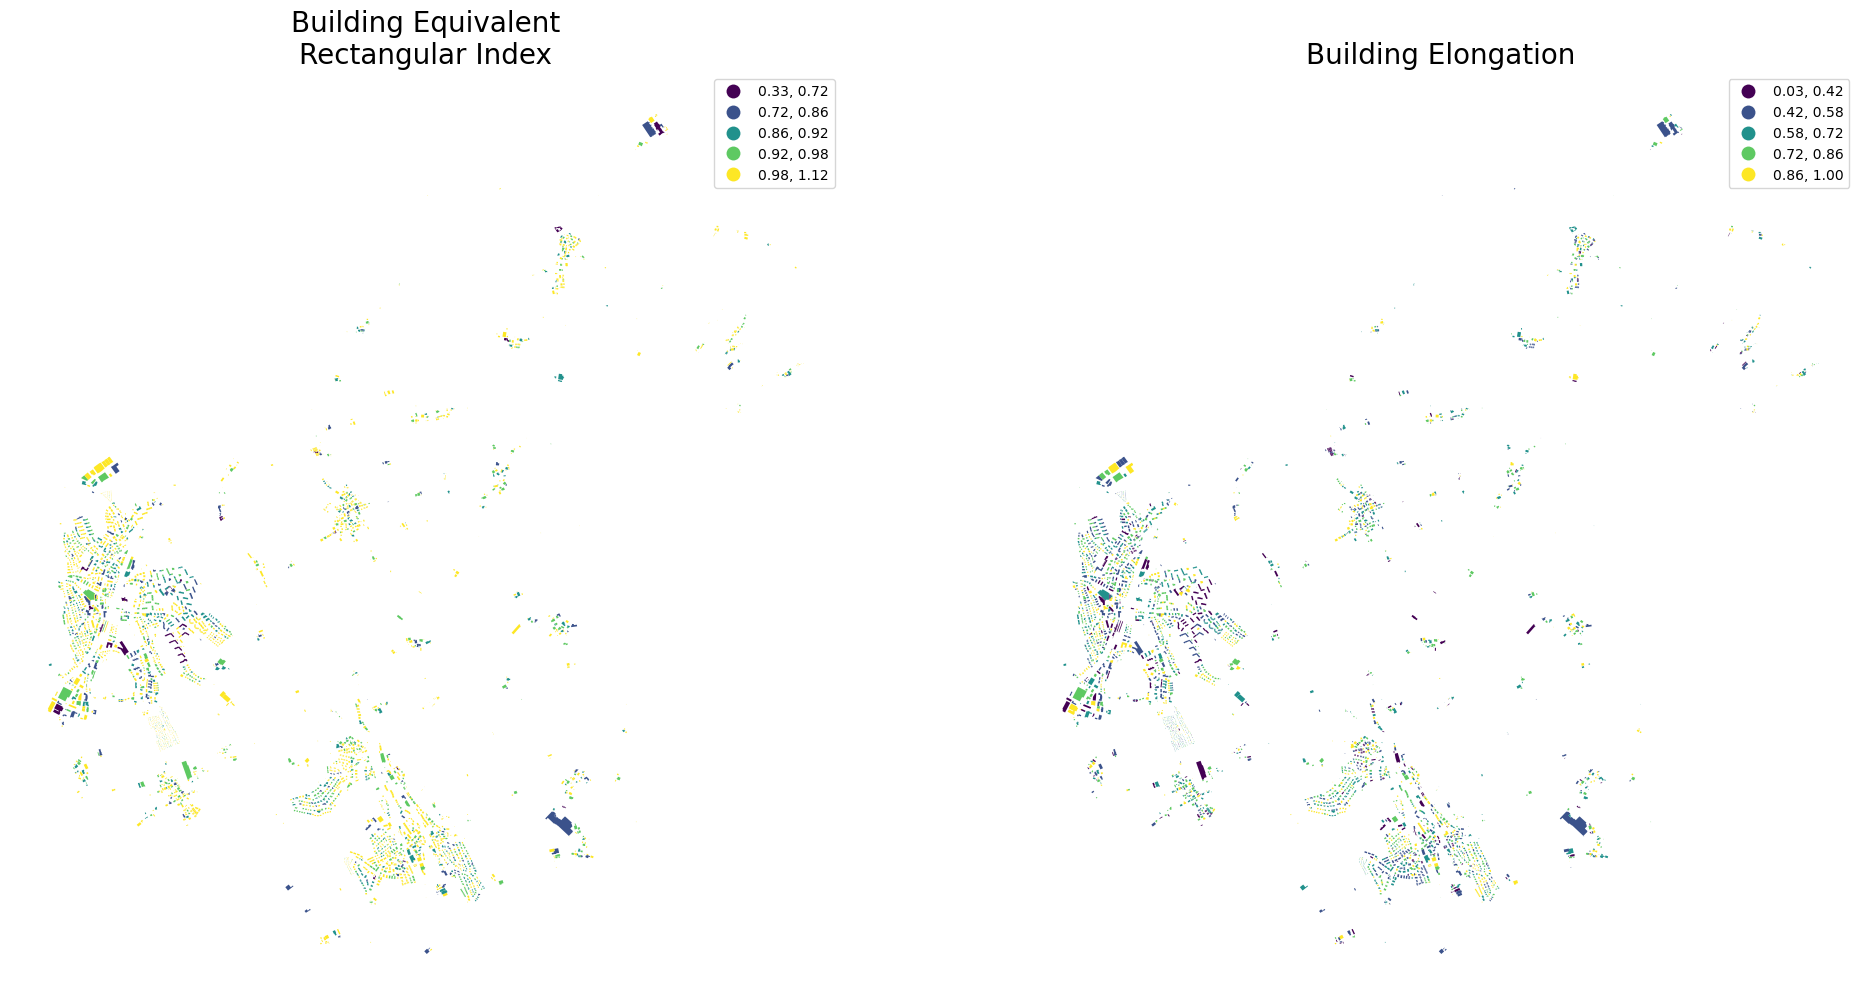

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("eri", ax=ax[0], scheme="natural_breaks", legend=True)
buildings.plot("elongation", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_title('Building Equivalent\nRectangular Index', fontsize=20)
ax[1].set_title('Building Elongation', fontsize=20)

ax[0].set_axis_off()
ax[1].set_axis_off()

plt.savefig('../results/Effretikon/eri_and_elongation.svg')  

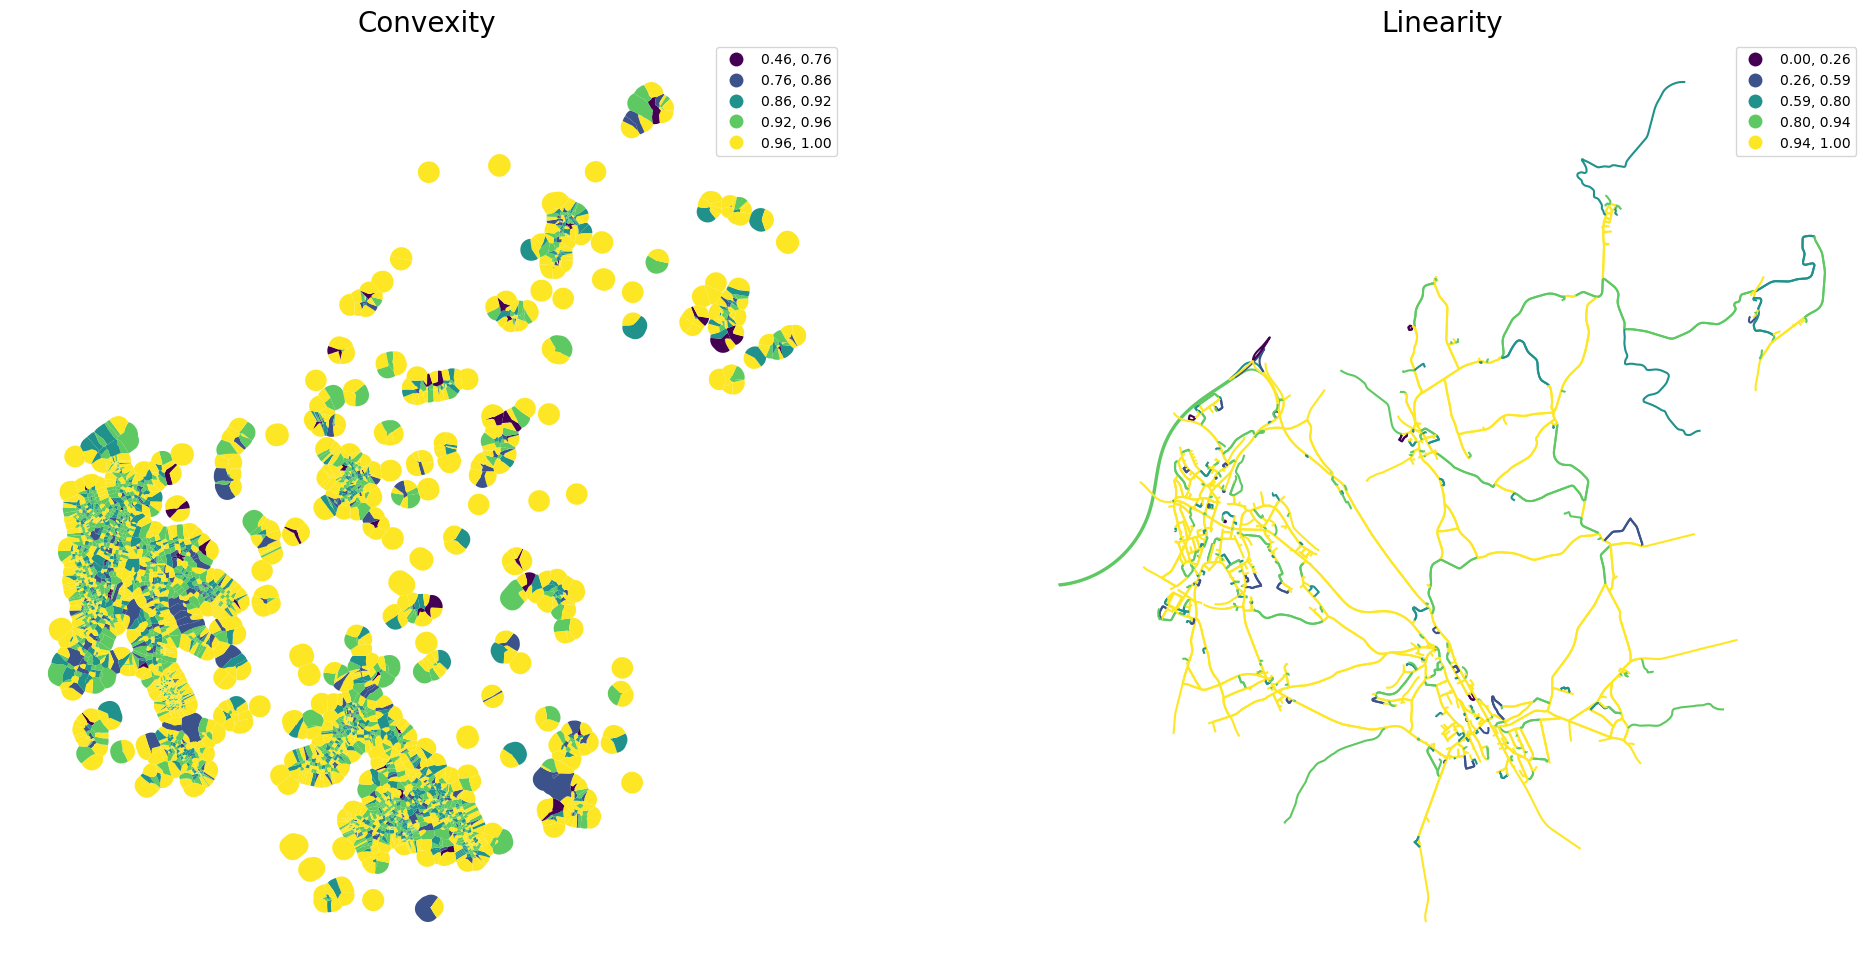

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("linearity", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_title('Convexity', fontsize=20)
ax[1].set_title('Linearity', fontsize=20)

ax[0].set_axis_off()
ax[1].set_axis_off()

plt.savefig('../results/Effretikon/convexity_and_linearity.svg')  

### Spatial distribution

In [32]:
buildings["shared_walls"] = momepy.SharedWallsRatio(buildings).series

/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/momepy/distribution.py:214: FutureWarning: Class based API like `momepy.SharedWalls` or `momepy.SharedWallsRatio` is deprecated. Replace it with `momepy.shared_walls` or explicitly computing `momepy.shared_walls / gdf.length` respectively to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  super().__init__(gdf)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


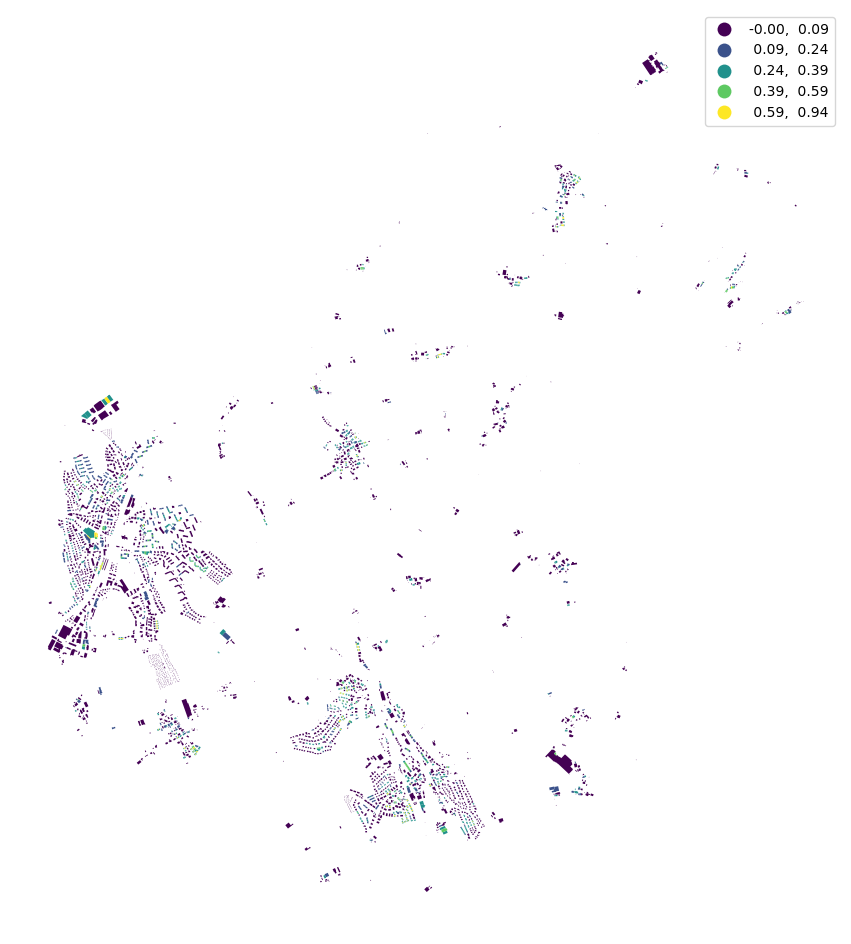

In [33]:
buildings.plot("shared_walls", figsize=(12, 12), scheme="natural_breaks", legend=True).set_axis_off()

plt.savefig('../results/Effretikon/sharedwalls.svg')  

Generate spatial weights matrix using `libpysal`.

In [34]:
queen_1 = libpysal.weights.contiguity.Queen.from_dataframe(tessellation, ids="uID", silence_warnings=True)

In [35]:
tessellation["neighbors"] = momepy.Neighbors(tessellation, queen_1, "uID", weighted=True, verbose=False).series
tessellation["covered_area"] = momepy.CoveredArea(tessellation, queen_1, "uID", verbose=False).series

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    buildings["neighbor_distance"] = momepy.NeighborDistance(buildings, queen_1, "uID", verbose=False).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42119/1669107924.py:1: FutureWarning: Class based API like `momepy.Neighbors` is deprecated. Replace it with `momepy.neighbors` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  tessellation["neighbors"] = momepy.Neighbors(tessellation, queen_1, "uID", weighted=True, verbose=False).series
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42119/1669107924.py:2: FutureWarning: `momepy.CoveredArea` is deprecated. Replace it with `.describe()` method of libpysal.graph.Graph or pin momepy version <1.0. This class will be removed in 1.0. 
  tessellation["covered_area"] = momepy.CoveredArea(tessellation, queen_1, "uID", verbose=False).series


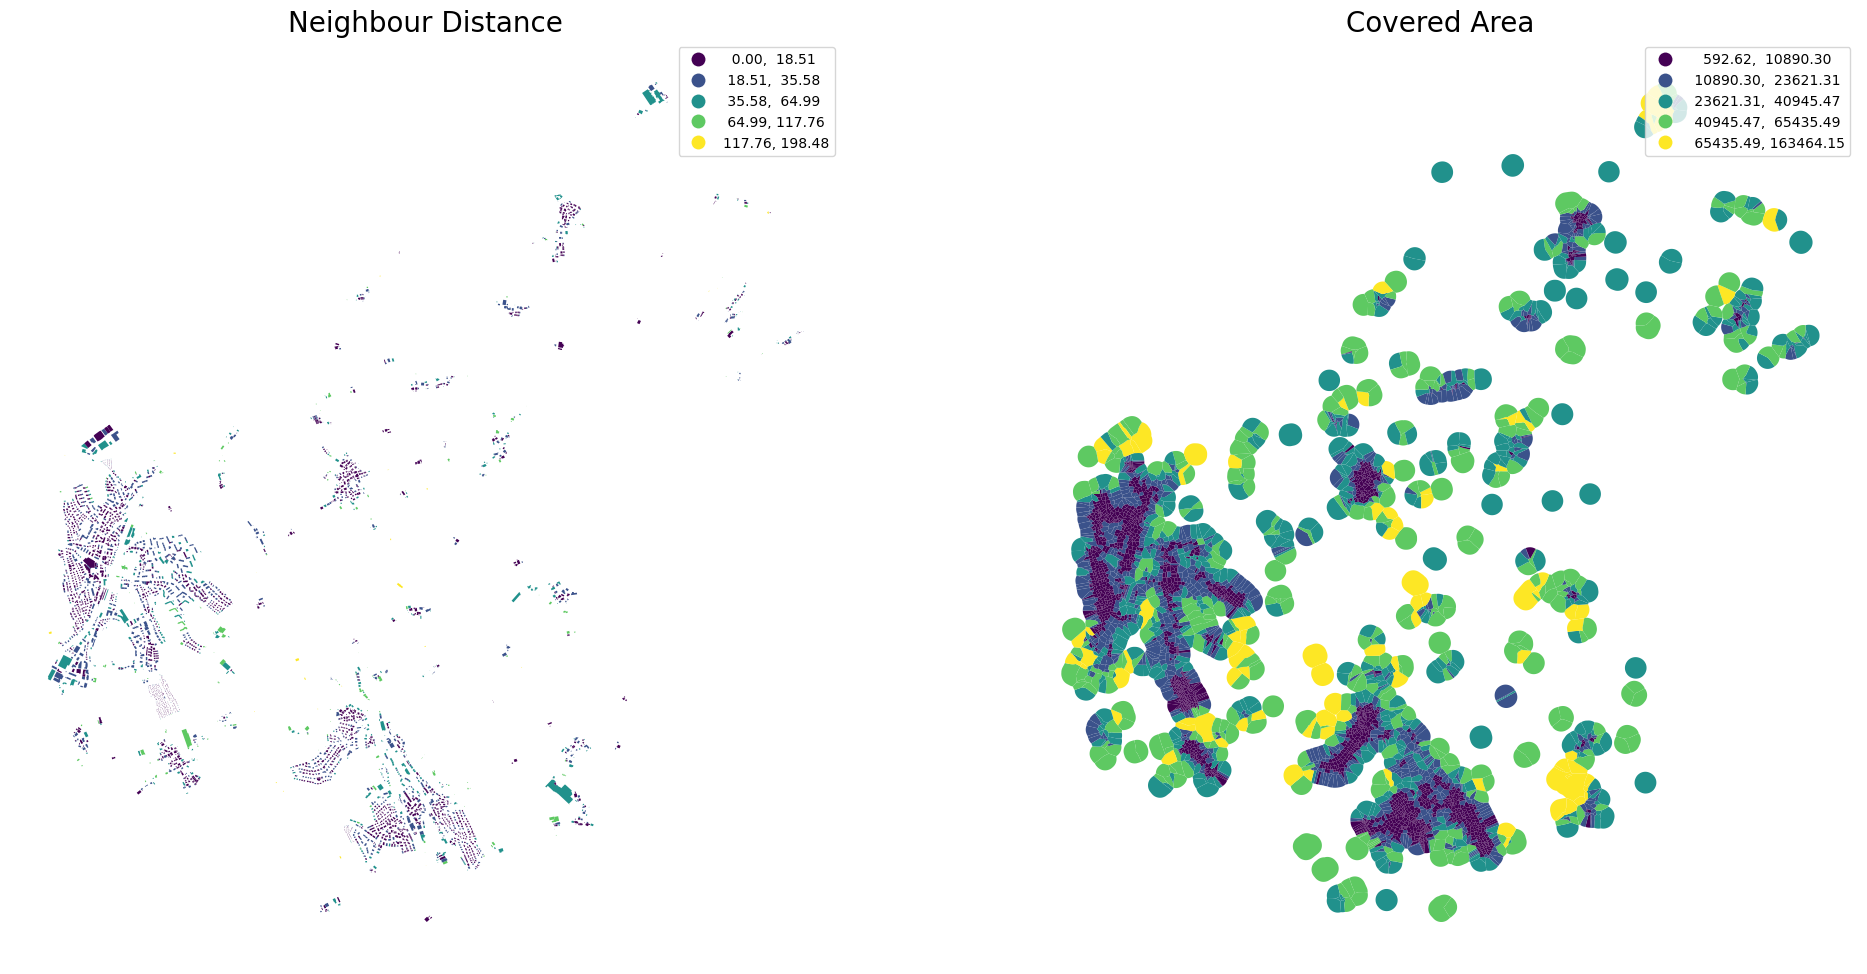

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("neighbor_distance", ax=ax[0], scheme="natural_breaks", legend=True)
tessellation.plot("covered_area", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_title('Neighbour Distance', fontsize=20)
ax[1].set_title('Covered Area', fontsize=20)


ax[0].set_axis_off()
ax[1].set_axis_off()

plt.savefig('../results/Effretikon/neighbourdist_and_coveredarea.svg')  

In [37]:
queen_3 = momepy.sw_high(k=3, weights=queen_1)
buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)

buildings['interbuilding_distance'] = momepy.MeanInterbuildingDistance(buildings, queen_1, 'uID', queen_3, verbose=False).series
buildings['adjacency'] = momepy.BuildingAdjacency(buildings, queen_3, 'uID', buildings_q1, verbose=False).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42119/3221532125.py:1: FutureWarning: `momepy.sw_high` is deprecated. Replace it with .higher_order() method of libpysal.graph.Graph or pin momepy version <1.0. This class will be removed in 1.0. 
  queen_3 = momepy.sw_high(k=3, weights=queen_1)
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42119/3221532125.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42119/3221532125.py:4: FutureWarning: Class based API like `momepy.MeanInterbuildingDistance` is deprecated. Replace it with `momepy.mean_interbuilding_distance` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings['interbuilding_distance'] 

In [38]:
#fig, ax = plt.subplots(1, 2, figsize=(24, 12))
#
#buildings.plot("interbuilding_distance", ax=ax[0], scheme="natural_breaks", legend=True)
#buildings.plot("adjacency", ax=ax[1], scheme="natural_breaks", legend=True)
#
#ax[0].set_axis_off()
#ax[1].set_axis_off()

In [39]:
profile = momepy.StreetProfile(streets, buildings)
streets["width"] = profile.w
streets["width_deviation"] = profile.wd
streets["openness"] = profile.o

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42119/2648127835.py:1: FutureWarning: Class based API like `momepy.StreetProfile` is deprecated. Replace it with `momepy.street_profile` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  profile = momepy.StreetProfile(streets, buildings)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: invalid value encountered in intersection
  return getattr(ufunc, method)(*new_inputs, **kwargs)


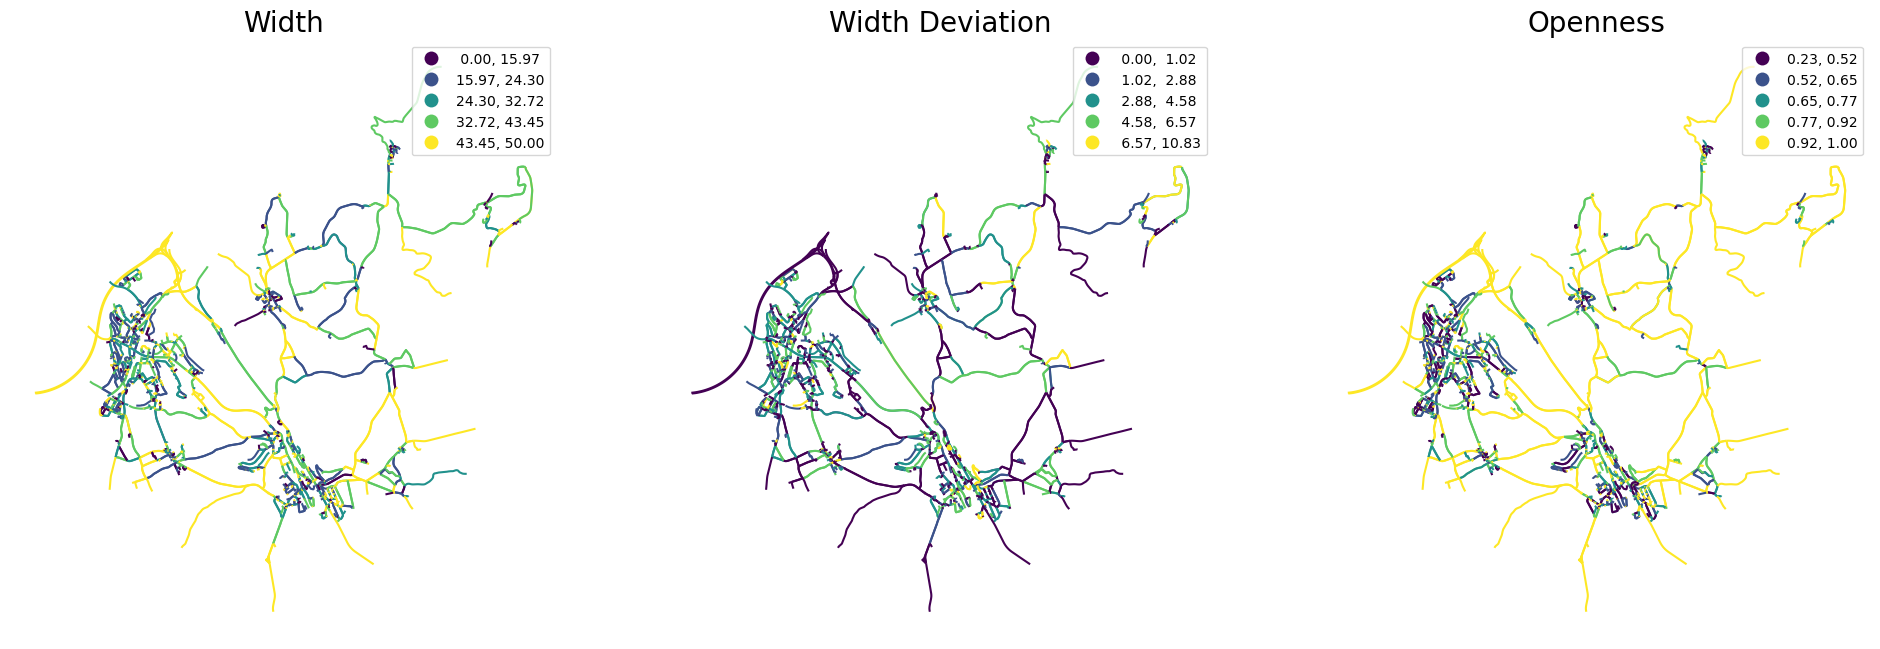

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

streets.plot("width", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("width_deviation", ax=ax[1], scheme="natural_breaks", legend=True)
streets.plot("openness", ax=ax[2], scheme="natural_breaks", legend=True)

ax[0].set_title('Width', fontsize=20)
ax[1].set_title('Width Deviation', fontsize=20)
ax[2].set_title('Openness', fontsize=20)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

plt.savefig('../results/Effretikon/road_network.svg')  

### Intensity

In [41]:
tessellation['car'] = momepy.AreaRatio(tessellation, buildings, 'area', 'area', 'uID').series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42119/1819725789.py:1: FutureWarning: `momepy.AreaRatio` is deprecated. Replace it with a direct division of areas or momepy.describe_agg() or pin momepy version <1.0. This class will be removed in 1.0. 
  tessellation['car'] = momepy.AreaRatio(tessellation, buildings, 'area', 'area', 'uID').series


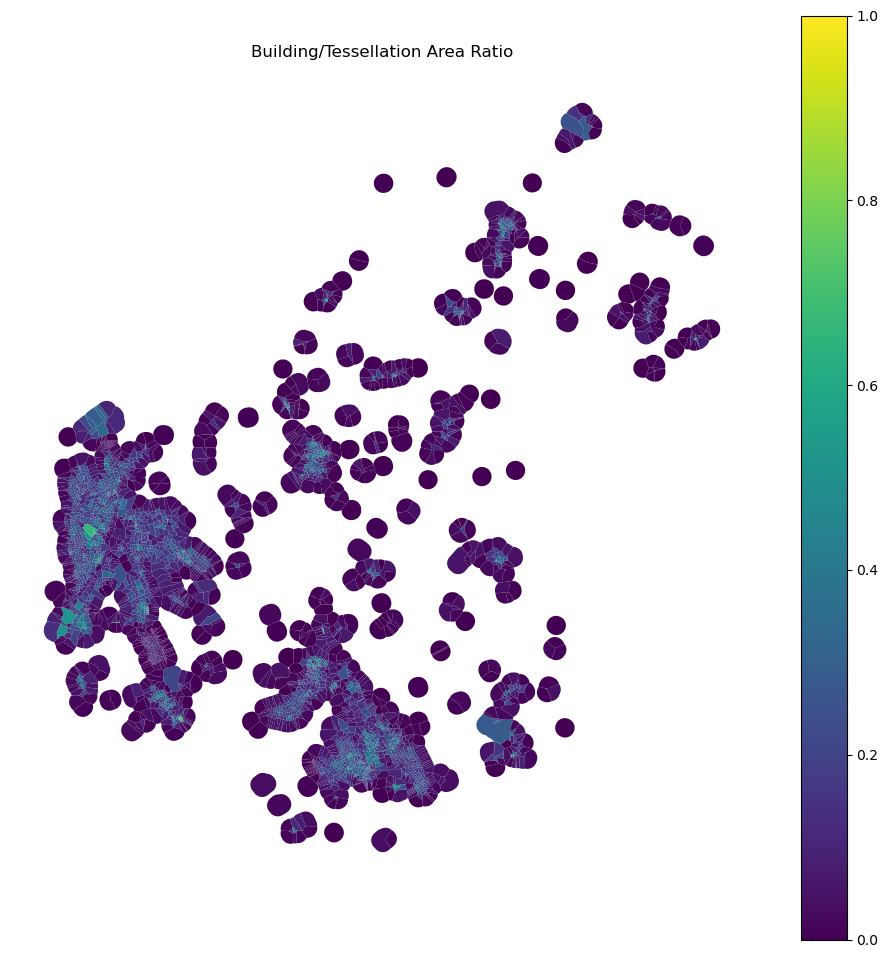

In [42]:
tessellation.plot("car", figsize=(12, 12), vmin=0, vmax=1, legend=True).set_axis_off()
plt.title("Building/Tessellation Area Ratio")

plt.savefig('../results/Effretikon/tessellation_ratio.svg')  

### Connectivity

In [43]:
graph = momepy.gdf_to_nx(streets)

In [44]:
graph = momepy.node_degree(graph)
graph = momepy.closeness_centrality(graph, radius=400, distance="mm_len")
graph = momepy.meshedness(graph, radius=400, distance="mm_len")

  0%|          | 0/1362 [00:00<?, ?it/s]

  0%|          | 0/1362 [00:00<?, ?it/s]

In [45]:
nodes, streets = momepy.nx_to_gdf(graph)

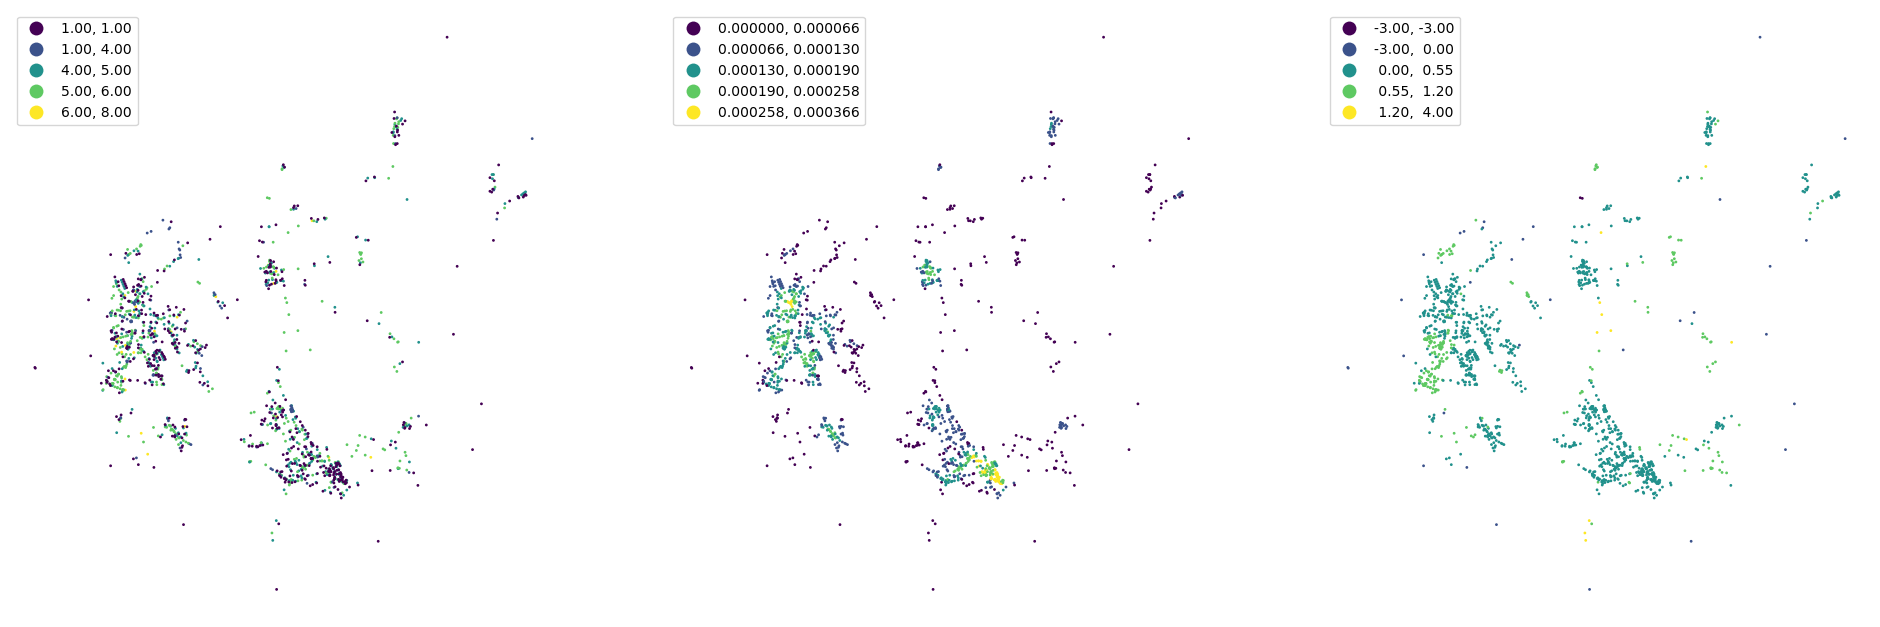

In [46]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

nodes.plot("degree", ax=ax[0], scheme="natural_breaks", legend=True, markersize=1)
nodes.plot("closeness", ax=ax[1], scheme="natural_breaks", legend=True, markersize=1, legend_kwds={"fmt": "{:.6f}"})
nodes.plot("meshedness", ax=ax[2], scheme="natural_breaks", legend=True, markersize=1)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

plt.savefig('../results/Effretikon/connectivity.svg')  

In [47]:
buildings["nodeID"] = momepy.get_node_id(buildings, nodes, streets, "nodeID", "nID")

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42119/403706460.py:1: FutureWarning: Class based API like `momepy.get_node_id` is deprecated. Replace it with `momepy.get_nearest_node` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings["nodeID"] = momepy.get_node_id(buildings, nodes, streets, "nodeID", "nID")


  0%|          | 0/4169 [00:00<?, ?it/s]

Link all data together (to tessellation cells or buildings).

In [48]:
tessellation

uID                                           geometry   nID  \
0     1772  POLYGON ((2696107.098 1250648.807, 2696128.878...   783   
1     1027  POLYGON ((2694449.441 1251803.561, 2694454.772...   707   
2     2209  POLYGON ((2693934.524 1251966.463, 2693954.427...   690   
3      653  POLYGON ((2693890.533 1252084.481, 2693891.863...   690   
4      649  POLYGON ((2693601.860 1252874.966, 2693605.750...  1984   
...    ...                                                ...   ...   
4164   522  POLYGON ((2694071.261 1254819.361, 2694071.098...  1737   
4165   731  POLYGON ((2694067.025 1254855.068, 2694066.236...  1746   
4166   527  POLYGON ((2694050.603 1254963.479, 2694050.011...  1742   
4167  1530  POLYGON ((2694165.865 1255050.419, 2694165.829...  1751   
4168  3369  POLYGON ((2697277.144 1257533.437, 2697277.712...  2566   

              area  convexity  neighbors  covered_area       car  
0     14792.129819   0.990054   0.006423  32430.449780  0.010016  
1     27870.065623   0.982583   0.003064  35790.391031  0.030164  
2     21899.073872   0.998766   0.003583  52399.623405  0.004744  
3     18247.903780   0.961021   0.009436  62440.608416  0.016182  
4     27294.004214   0.939600   0.007698  58116.878985  0.133431  
...            ...        ...        ...           ...       ...  
4164   5298.004321   0.938241   0.020742  47063.812956  0.215611  
4165   3192.479143   0.923415   0.025476  55842.506190  0.303172  
4166   5832.824097   0.944749   0.010409  52366.419586  0.293779  
4167   5662.413630   0.945228   0.011232  86090.153654  0.319234  
4168  33225.690966   1.000000   0.000000  33225.690966  0.000573  

[4169 rows x 8 columns]

In [49]:
merged = tessellation.merge(buildings.drop(columns=['nID', 'geometry']), on='uID')
merged = merged.merge(streets.drop(columns='geometry'), on='nID', how='left')
merged = merged.merge(nodes.drop(columns='geometry'), on='nodeID', how='left')

In [50]:
merged.columns

Index(['uID', 'geometry', 'nID', 'area_x', 'convexity', 'neighbors',
       'covered_area', 'car', 'area_y', 'eri', 'elongation', 'shared_walls',
       'neighbor_distance', 'interbuilding_distance', 'adjacency', 'nodeID',
       'length', 'linearity', 'width', 'width_deviation', 'openness', 'mm_len',
       'node_start', 'node_end', 'x', 'y', 'degree', 'closeness',
       'meshedness'],
      dtype='object')

## Understanding the context

Measure first, second and third quartile of distribution of values within an area around each building.

In [51]:
percentiles = []
for column in merged.columns.drop(["uID", "nodeID", "nID", 'mm_len', 'node_start', 'node_end', "geometry"]):
    perc = momepy.Percentiles(merged, column, queen_3, "uID", verbose=False).frame
    perc.columns = [f"{column}_" + str(x) for x in perc.columns]
    percentiles.append(perc)

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42119/962013058.py:3: FutureWarning: Class based API like `momepy.Percentiles` is deprecated. Replace it with `momepy.percentile` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  perc = momepy.Percentiles(merged, column, queen_3, "uID", verbose=False).frame
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42119/962013058.py:3: FutureWarning: Class based API like `momepy.Percentiles` is deprecated. Replace it with `momepy.percentile` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  perc = momepy.Percentiles(merged, column, queen_3, "uID", verbose=False).frame
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42119/962013058.py:3: FutureWarning: Class based API like `momepy.Percentiles` is deprecated. Replace it with `momepy.percentile` to use functional API instead or pin momepy version <1.0. Class-based API

In [52]:
percentiles_joined = pandas.concat(percentiles, axis=1)

In [53]:
percentiles_joined

area_x_25     area_x_50     area_x_75  convexity_25  convexity_50  \
0      2694.293802   9609.755445  11882.564272      0.922961      0.953757   
1      3357.960635   5038.518385  13319.019554      0.950412      0.982384   
2      1305.062165   3692.296714   7095.435283      0.954299      0.966847   
3      1087.669951   2741.651927   7095.435283      0.954299      0.966847   
4      1963.301323   2671.033455   9093.752146      0.919353      0.946361   
...            ...           ...           ...           ...           ...   
4164    746.060581   2913.430866   7213.414982      0.941352      0.966783   
4165    746.060581   4087.362723   9004.213298      0.927727      0.959870   
4166    746.060581   4087.362723   9004.213298      0.927727      0.959870   
4167    656.547935   3973.807756   7678.901916      0.926180      0.952957   
4168  33225.690966  33225.690966  33225.690966      1.000000      1.000000   

      convexity_75  neighbors_25  neighbors_50  neighbors_75  covered_area_25  \
0         0.985205      0.008784      0.012226      0.019908     31827.697084   
1         0.989155      0.011247      0.011837      0.015054     40751.271391   
2         0.972917      0.012148      0.019640      0.028430     22122.550392   
3         0.975614      0.011077      0.019640      0.032779     20308.685141   
4         0.970500      0.013819      0.022168      0.028943     29364.056002   
...            ...           ...           ...           ...              ...   
4164      0.985033      0.010905      0.024721      0.044210     12099.279240   
4165      0.985477      0.009990      0.023340      0.048128     12913.799979   
4166      0.985214      0.009990      0.021386      0.048128     13930.425542   
4167      0.984770      0.010409      0.022030      0.049171     11346.404458   
4168      1.000000      0.000000      0.000000      0.000000     33225.690966   

      ...          y_75  degree_25  degree_50  degree_75  closeness_25  \
0     ...  1.250624e+06        5.0        5.0        5.0      0.000011   
1     ...  1.251698e+06        7.0        7.0        7.0      0.000017   
2     ...  1.252229e+06        6.0        6.0        6.0      0.000035   
3     ...  1.252229e+06        6.0        6.0        6.0      0.000035   
4     ...  1.252956e+06        5.0        5.5        6.0      0.000069   
...   ...           ...        ...        ...        ...           ...   
4164  ...  1.254892e+06        5.0        5.0        5.0      0.000050   
4165  ...  1.254927e+06        5.0        5.0        5.0      0.000050   
4166  ...  1.254927e+06        5.0        5.0        5.0      0.000050   
4167  ...  1.254927e+06        5.0        5.0        5.0      0.000050   
4168  ...  1.257030e+06        5.0        5.0        5.0      0.000134   

      closeness_50  closeness_75  meshedness_25  meshedness_50  meshedness_75  
0         0.000011      0.000011       1.333333       1.333333       1.333333  
1         0.000017      0.000017       0.333333       0.333333       0.333333  
2         0.000047      0.000047       0.538462       0.538462       0.538462  
3         0.000047      0.000047       0.538462       0.538462       0.538462  
4         0.000112      0.000157       0.653266       0.682731       0.707001  
...            ...           ...            ...            ...            ...  
4164      0.000050      0.000053       0.459459       0.459459       0.777778  
4165      0.000050      0.000054       0.459459       0.459459       0.777778  
4166      0.000050      0.000054       0.459459       0.459459       0.777778  
4167      0.000050      0.000055       0.459459       0.459459       0.777778  
4168      0.000134      0.000134       0.457627       0.457627       0.457627  

[4169 rows x 66 columns]

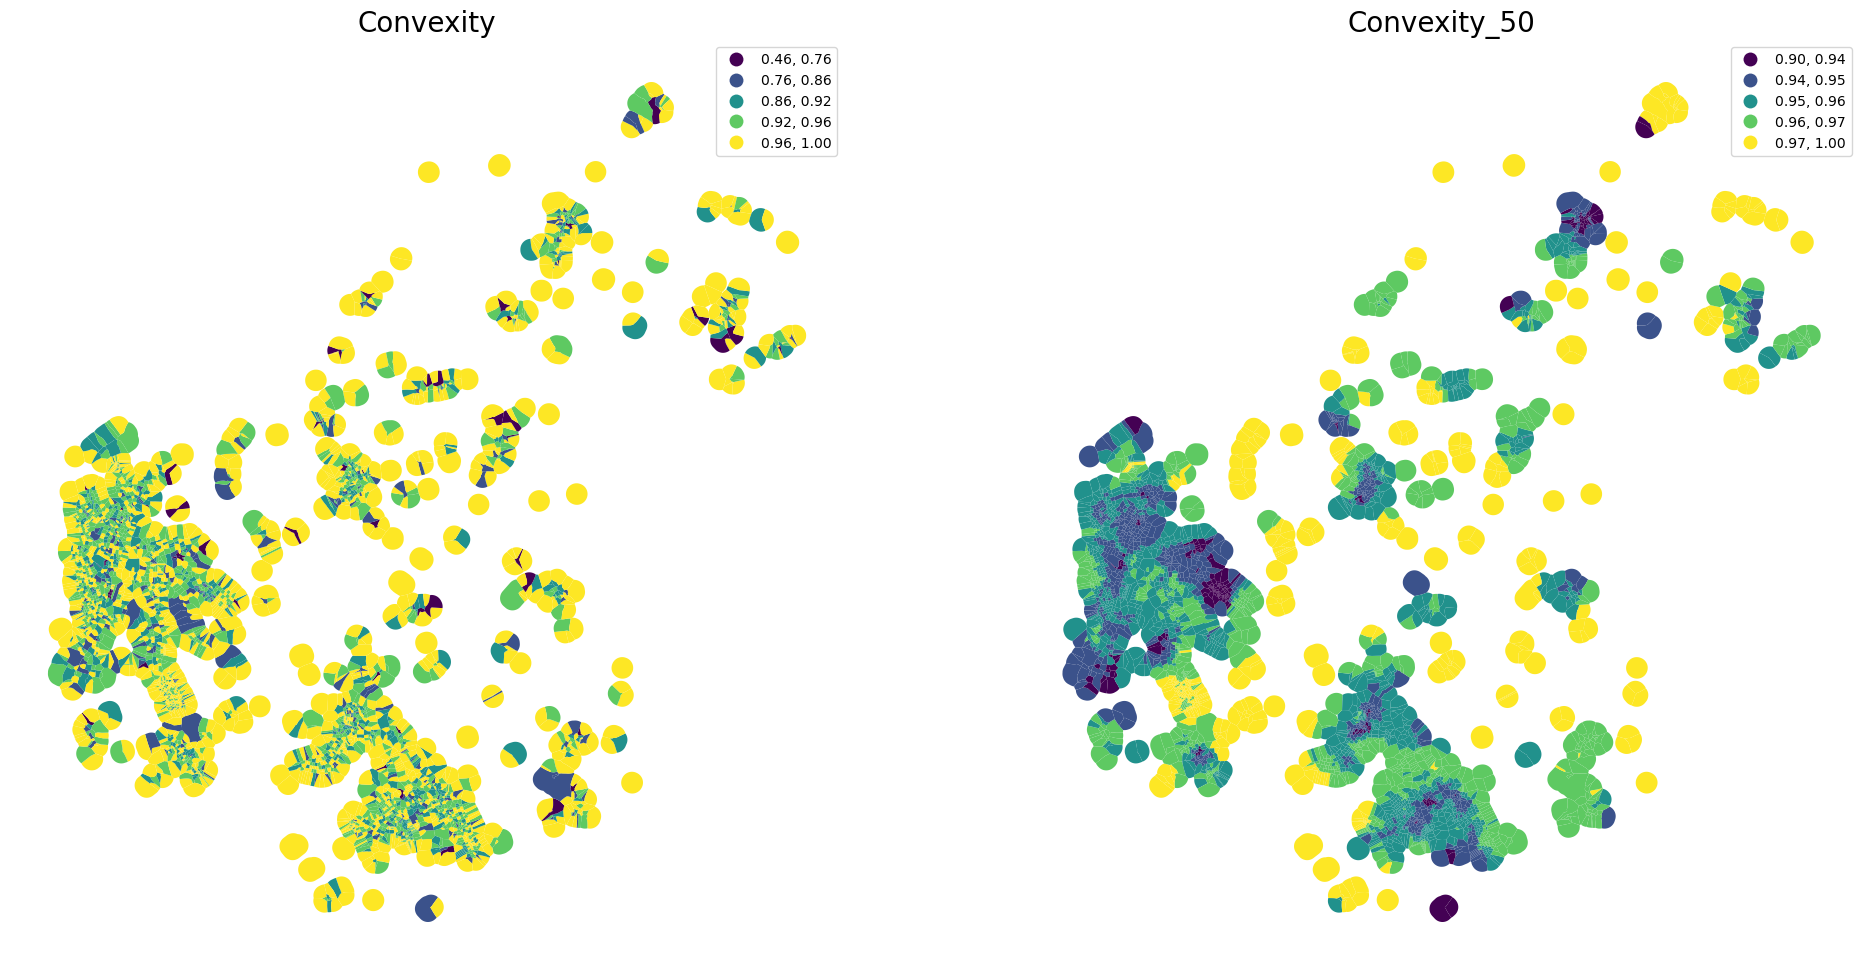

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
merged.plot(percentiles_joined['convexity_50'].values, ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_title('Convexity', fontsize=20)
ax[1].set_title('Convexity_50', fontsize=20)

ax[0].set_axis_off()
ax[1].set_axis_off()

plt.savefig('../results/Effretikon/convexity.svg')  

## Clustering

Standardize values before clustering.

In [57]:
standardized = (percentiles_joined - percentiles_joined.mean()) / percentiles_joined.std()

In [58]:
standardized

area_x_25  area_x_50  area_x_75  convexity_25  convexity_50  \
0      0.438860   2.058473   1.841800     -0.045175     -0.343718   
1      0.641010   0.809353   2.164551      1.117188      1.745258   
2      0.015705   0.441489   0.766202      1.281754      0.611467   
3     -0.050512   0.181719   0.766202      1.281754      0.611467   
4      0.216202   0.162422   1.215195     -0.197931     -0.883434   
...         ...        ...        ...           ...           ...   
4164  -0.154565   0.228659   0.792710      0.733561      0.606826   
4165  -0.154565   0.549443   1.195077      0.156609      0.102349   
4166  -0.154565   0.549443   1.195077      0.156609      0.102349   
4167  -0.181830   0.518414   0.897299      0.091111     -0.402128   
4168   9.738611   8.511680   6.637291      3.216853      3.030736   

      convexity_75  neighbors_25  neighbors_50  neighbors_75  covered_area_25  \
0         0.813439     -1.330294     -1.531054     -1.550591         2.335378   
1         1.226984     -1.176980     -1.551475     -1.776722         3.290313   
2        -0.472987     -1.120908     -1.141151     -1.153600         1.296804   
3        -0.190615     -1.187540     -1.141151     -0.951037         1.102698   
4        -0.726014     -1.016897     -1.008155     -1.129704         2.071737   
...            ...           ...           ...           ...              ...   
4164      0.795474     -1.198249     -0.873933     -0.418518         0.224188   
4165      0.841968     -1.255212     -0.946559     -0.236031         0.311352   
4166      0.814359     -1.255212     -1.049316     -0.236031         0.420144   
4167      0.767864     -1.229119     -1.015435     -0.187438         0.143621   
4168      2.362344     -1.876930     -2.174024     -2.477977         2.484981   

      ...      y_75  degree_25  degree_50  degree_75  closeness_25  \
0     ... -1.767589   0.941956   0.114109  -0.592713     -1.389389   
1     ... -1.056964   1.959121   1.624332   1.521076     -1.278121   
2     ... -0.705682   1.450539   0.869221   0.464182     -0.959024   
3     ... -0.705682   1.450539   0.869221   0.464182     -0.959024   
4     ... -0.224286   0.941956   0.491665   0.464182     -0.358983   
...   ...       ...        ...        ...        ...           ...   
4164  ...  1.057171   0.941956   0.114109  -0.592713     -0.693467   
4165  ...  1.080527   0.941956   0.114109  -0.592713     -0.693467   
4166  ...  1.080527   0.941956   0.114109  -0.592713     -0.693467   
4167  ...  1.080527   0.941956   0.114109  -0.592713     -0.693467   
4168  ...  2.472588   0.941956   0.114109  -0.592713      0.791779   

      closeness_50  closeness_75  meshedness_25  meshedness_50  meshedness_75  
0        -1.543239     -1.661057       3.780619       3.632099       3.452271  
1        -1.448662     -1.576935      -0.273355      -0.360916      -0.462055  
2        -0.993347     -1.171960       0.558230       0.458164       0.340884  
3        -0.993347     -1.171960       0.558230       0.458164       0.340884  
4        -0.023096      0.286075       1.023642       1.034234       1.000600  
...            ...           ...            ...            ...            ...  
4164     -0.951706     -1.103516       0.237957       0.142708       1.277645  
4165     -0.951706     -1.087944       0.237957       0.142708       1.277645  
4166     -0.951706     -1.087944       0.237957       0.142708       1.277645  
4167     -0.951706     -1.072373       0.237957       0.142708       1.277645  
4168      0.310754     -0.012040       0.230529       0.135391       0.024471  

[4169 rows x 66 columns]

### How many clusters?

In [59]:
cgram = Clustergram(range(1, 12), n_init=10, random_state=0)
cgram.fit(standardized.fillna(0))

K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.041 seconds.
K=3 fitted in 0.057 seconds.
K=4 fitted in 0.054 seconds.
K=5 fitted in 0.064 seconds.
K=6 fitted in 0.099 seconds.
K=7 fitted in 0.082 seconds.
K=8 fitted in 0.093 seconds.
K=9 fitted in 0.093 seconds.
K=10 fitted in 0.108 seconds.
K=11 fitted in 0.130 seconds.


Clustergram(k_range=range(1, 12), backend='sklearn', method='kmeans', kwargs={'n_init': 10, 'random_state': 0})

In [60]:
show(cgram.bokeh())

In [61]:
cgram.labels.head()

1   2   3   4   5   6   7   8   9   10  11
0   0   1   1   2   2   5   1   5   1   3   2
1   0   1   1   1   2   5   1   5   2   2   2
2   0   1   1   2   2   5   1   5   2   2   4
3   0   1   1   2   2   5   1   5   2   2   4
4   0   1   2   2   0   4   3   5   2   9   4

In [62]:
merged["cluster"] = cgram.labels[8].values

In [63]:
urban_types = buildings[["geometry", "uID"]].merge(merged[["uID", "cluster"]], on="uID")

In [64]:
urban_types.explore("cluster", categorical=True, prefer_canvas=True, tiles="CartoDB Positron", tooltip=False)

## Export

Save cluster output geodata to geojson file:

In [65]:
urban_types.to_file('../data/raw/Effretikon.geojson', driver='GeoJSON')

## Utilities

Once you run the cell below, it hides all cells below the currently active one (aka presentation mode).

In [ ]:
%%html
<style>
.jp-Cell.jp-mod-selected ~ .jp-Cell {
    display: none;
}
</style>

Run this cell to turn the presentation mode off.

In [ ]:
%%html
<style>
.jp-Cell.jp-mod-selected ~ .jp-Cell {
    display: block;
}
</style>